In [1]:
import pandas as pd
from clearml import Task
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import mannwhitneyu
import gc


def exp_decay(t, a, b, c):
    return a * np.exp(-b * t) + c


def download_and_process_tasks_batch(tag, experiment_name, batch_size=20):
    print(f"DOWNLOADING TASKS FOR {experiment_name}: {tag}")

    tasks = Task.get_tasks(project_name="oho", tags=[tag])
    print(f"Found {len(tasks)} tasks")

    all_dfs = []

    for batch_start in range(0, len(tasks), batch_size):
        batch_end = min(batch_start + batch_size, len(tasks))
        batch_tasks = tasks[batch_start:batch_end]
        print(f"Processing batch {batch_start + 1}-{batch_end}/{len(tasks)}")

        data_rows = []

        for task in batch_tasks:
            base_task_data = {"task_id": task.id, "task_name": task.name}

            # Get config
            params = task.get_parameters() or {}
            for key, value in params.items():
                if any(x in key for x in ["learning_rate", "optimizer/_type", "seed/global_seed"]):
                    base_task_data[key] = value

            # Get ALL metrics from reported_scalars consistently
            reported_scalars = task.get_reported_scalars()

            for metric_name in ["validation/loss", "test/loss", "final_test/loss", "train/learning_rate"]:
                if metric_name in reported_scalars:
                    variants = reported_scalars[metric_name]
                    for variant, data in variants.items():
                        if data["x"] and data["y"]:
                            for iteration, value in zip(data["x"], data["y"]):
                                if isinstance(value, (int, float)):
                                    row = base_task_data.copy()
                                    row["iteration"] = iteration
                                    row[f"metric/{metric_name}/{variant}"] = value
                                    data_rows.append(row)

            # Only add base task data if no time series data was added
            if not any(metric in reported_scalars for metric in ["validation/loss", "test/loss", "final_test/loss", "train/learning_rate"]):
                data_rows.append(base_task_data)

        if data_rows:
            batch_df = pd.DataFrame(data_rows)
            all_dfs.append(batch_df)

        gc.collect()

    if all_dfs:
        df = pd.concat(all_dfs, ignore_index=True)
    else:
        df = pd.DataFrame()

    print(f"DataFrame created: {df.shape}")
    if not df.empty:
        final_test_cols = [col for col in df.columns if "final_test" in col and "loss" in col]
        print(f"Final test loss columns found: {final_test_cols}")

        # Check for zero values
        if final_test_cols:
            final_test_col = final_test_cols[0]
            zero_count = (df[final_test_col] == 0).sum()
            if zero_count > 0:
                print(f"WARNING: {zero_count} zero values detected in final test loss!")
                zero_tasks = df[df[final_test_col] == 0]["task_id"].unique()
                print(f"Tasks with zero final test loss: {zero_tasks[:5]}...")

    return df


def analyze_single_optimizer(df, experiment_name):
    print(f"ANALYZING {experiment_name}")

    final_test_cols = [col for col in df.columns if "final_test" in col and "loss" in col]
    if not final_test_cols:
        print("ERROR: No final test loss column found")
        return {}
    final_test_col = final_test_cols[0]

    validation_data = df.dropna(
        subset=["metric/validation/loss/validation_loss", "config/learners/0/optimizer/learning_rate"]
    )

    # Get all learning rates and check each for zero final test losses
    learning_rates = validation_data["config/learners/0/optimizer/learning_rate"].unique()
    valid_lrs = []

    for lr in learning_rates:
        # Get final test data for this learning rate
        final_test_data = df.dropna(subset=[final_test_col, "config/learners/0/optimizer/learning_rate"])
        lr_final_test = final_test_data[final_test_data["config/learners/0/optimizer/learning_rate"] == lr]
        unique_final_test = lr_final_test.drop_duplicates(["task_id"])
        final_losses = unique_final_test[final_test_col].values

        # Check for zeros
        zero_count = (final_losses == 0).sum()
        if zero_count == 0:
            valid_lrs.append(lr)
        else:
            print(f"EXCLUDING learning rate {lr}: {zero_count} tasks have zero final test loss")

    if not valid_lrs:
        print("ERROR: No valid learning rates found (all have zero final test losses)")
        return {}

    print(f"Valid learning rates: {len(valid_lrs)}/{len(learning_rates)}")

    # Filter validation data to only valid learning rates
    valid_validation_data = validation_data[
        validation_data["config/learners/0/optimizer/learning_rate"].isin(valid_lrs)
    ]

    # Get best learning rate from valid ones
    last_iter_validation = (
        valid_validation_data.groupby(["task_id", "config/learners/0/optimizer/learning_rate"])
        .agg({"iteration": "max", "metric/validation/loss/validation_loss": "last"})
        .reset_index()
    )

    last_iter_validation = valid_validation_data.merge(
        last_iter_validation[["task_id", "config/learners/0/optimizer/learning_rate", "iteration"]],
        on=["task_id", "config/learners/0/optimizer/learning_rate", "iteration"],
    )

    lr_validation_summary = last_iter_validation.groupby("config/learners/0/optimizer/learning_rate").agg(
        {"metric/validation/loss/validation_loss": "mean"}
    )

    best_lr = lr_validation_summary["metric/validation/loss/validation_loss"].idxmin()
    print(f"Best learning rate: {best_lr}")

    # Get final test losses for best LR
    final_test_data = df.dropna(subset=[final_test_col, "config/learners/0/optimizer/learning_rate"])
    best_lr_final_test = final_test_data[final_test_data["config/learners/0/optimizer/learning_rate"] == best_lr]
    unique_final_test = best_lr_final_test.drop_duplicates(["task_id"])
    final_losses = unique_final_test[final_test_col].values

    print(f"Tasks with best LR: {len(unique_final_test)}")
    print(f"Final test loss: mean={np.mean(final_losses):.6f}, std={np.std(final_losses):.6f}, n={len(final_losses)}")

    # Get effective learning rates
    test_loss_curves = df[
        (df["config/learners/0/optimizer/learning_rate"] == best_lr) & df["metric/test/loss/test_loss"].notna()
    ]

    effective_learning_rates = []
    if not test_loss_curves.empty:
        best_lr_seeds = test_loss_curves["config/seed/global_seed"].unique()

        for seed in best_lr_seeds:
            seed_data = test_loss_curves[test_loss_curves["config/seed/global_seed"] == seed]
            if len(seed_data) > 5:
                try:
                    popt, _ = curve_fit(
                        exp_decay,
                        seed_data["iteration"].values,
                        seed_data["metric/test/loss/test_loss"].values,
                        bounds=([0, 0, 0], [np.inf, np.inf, np.inf]),
                        maxfev=2000,
                    )
                    effective_learning_rates.append(popt[1])
                except:
                    continue

    if effective_learning_rates:
        print(
            f"Effective LR: mean={np.mean(effective_learning_rates):.6f}, std={np.std(effective_learning_rates):.6f}, n={len(effective_learning_rates)}"
        )

    return {
        "single_optimizer": {
            "best_lr0": best_lr,
            "final_losses": final_losses,
            "effective_learning_rates": effective_learning_rates,
            "learning_rate_curves": {},  # No learning rate curves for single optimizer
        }
    }


def analyze_dual_optimizer(df, experiment_name):
    print(f"ANALYZING {experiment_name}")

    final_test_cols = [col for col in df.columns if "final_test" in col and "loss" in col]
    if not final_test_cols:
        print("ERROR: No final test loss column found")
        return {}
    final_test_col = final_test_cols[0]

    optimizer_types = df["config/learners/0/optimizer/_type"].dropna().unique()
    print(f"Optimizer types: {optimizer_types}")

    results = {}

    for opt_type in optimizer_types:
        print(f"\nAnalyzing {opt_type}")
        opt_df = df[df["config/learners/0/optimizer/_type"] == opt_type]

        validation_data = opt_df.dropna(
            subset=[
                "metric/validation/loss/validation_loss",
                "config/learners/0/optimizer/learning_rate",
                "config/learners/1/optimizer/learning_rate",
            ]
        )

        if validation_data.empty:
            continue

        # Get all LR pairs and check each for zero final test losses
        lr_pairs = validation_data[
            ["config/learners/0/optimizer/learning_rate", "config/learners/1/optimizer/learning_rate"]
        ].drop_duplicates()
        valid_lr_pairs = []

        for _, row in lr_pairs.iterrows():
            lr0, lr1 = (
                row["config/learners/0/optimizer/learning_rate"],
                row["config/learners/1/optimizer/learning_rate"],
            )

            # Get final test data for this LR pair
            final_test_data = opt_df.dropna(subset=[final_test_col])
            pair_final_test = final_test_data[
                (final_test_data["config/learners/0/optimizer/learning_rate"] == lr0)
                & (final_test_data["config/learners/1/optimizer/learning_rate"] == lr1)
            ]
            unique_final_test = pair_final_test.drop_duplicates(["task_id"])
            final_losses = unique_final_test[final_test_col].values

            # Check for zeros
            zero_count = (final_losses == 0).sum()
            if zero_count == 0 and len(final_losses) > 0:
                valid_lr_pairs.append((lr0, lr1))
            elif zero_count > 0:
                print(f"EXCLUDING LR pair ({lr0}, {lr1}): {zero_count} tasks have zero final test loss")

        if not valid_lr_pairs:
            print(f"ERROR: No valid LR pairs found for {opt_type}")
            continue

        print(f"Valid LR pairs for {opt_type}: {len(valid_lr_pairs)}/{len(lr_pairs)}")

        # Filter validation data to only valid LR pairs
        valid_mask = validation_data.apply(
            lambda x: (x["config/learners/0/optimizer/learning_rate"], x["config/learners/1/optimizer/learning_rate"])
            in valid_lr_pairs,
            axis=1,
        )
        valid_validation_data = validation_data[valid_mask]

        # Find best LR pair from valid ones
        last_iter_validation = (
            valid_validation_data.groupby(
                ["task_id", "config/learners/0/optimizer/learning_rate", "config/learners/1/optimizer/learning_rate"]
            )
            .agg({"iteration": "max", "metric/validation/loss/validation_loss": "last"})
            .reset_index()
        )

        last_iter_validation = valid_validation_data.merge(
            last_iter_validation[
                [
                    "task_id",
                    "config/learners/0/optimizer/learning_rate",
                    "config/learners/1/optimizer/learning_rate",
                    "iteration",
                ]
            ],
            on=[
                "task_id",
                "config/learners/0/optimizer/learning_rate",
                "config/learners/1/optimizer/learning_rate",
                "iteration",
            ],
        )

        lr_validation_summary = last_iter_validation.groupby(
            ["config/learners/0/optimizer/learning_rate", "config/learners/1/optimizer/learning_rate"]
        ).agg({"metric/validation/loss/validation_loss": "mean"})

        best_idx = lr_validation_summary["metric/validation/loss/validation_loss"].idxmin()
        best_lr0, best_lr1 = best_idx
        print(f"Best LR pair: learner0={best_lr0}, learner1={best_lr1}")

        # Get final test losses for best LR pair
        final_test_data = opt_df.dropna(subset=[final_test_col])
        best_lr_final_test = final_test_data[
            (final_test_data["config/learners/0/optimizer/learning_rate"] == best_lr0)
            & (final_test_data["config/learners/1/optimizer/learning_rate"] == best_lr1)
        ]

        unique_final_test = best_lr_final_test.drop_duplicates(["task_id"])
        final_losses = unique_final_test[final_test_col].values

        print(f"Tasks with best LR pair: {len(unique_final_test)}")
        print(
            f"Final test loss: mean={np.mean(final_losses):.6f}, std={np.std(final_losses):.6f}, n={len(final_losses)}"
        )

        # Get effective learning rates
        test_loss_curves = opt_df[
            (opt_df["config/learners/0/optimizer/learning_rate"] == best_lr0)
            & (opt_df["config/learners/1/optimizer/learning_rate"] == best_lr1)
            & opt_df["metric/test/loss/test_loss"].notna()
        ]

        effective_learning_rates = []
        if not test_loss_curves.empty:
            best_lr_seeds = test_loss_curves["config/seed/global_seed"].unique()
            for seed in best_lr_seeds:
                seed_data = test_loss_curves[test_loss_curves["config/seed/global_seed"] == seed]
                if len(seed_data) > 5:
                    try:
                        popt, _ = curve_fit(
                            exp_decay,
                            seed_data["iteration"].values,
                            seed_data["metric/test/loss/test_loss"].values,
                            bounds=([0, 0, 0], [np.inf, np.inf, np.inf]),
                            maxfev=2000,
                        )
                        effective_learning_rates.append(popt[1])
                    except:
                        continue

        if effective_learning_rates:
            print(
                f"Effective LR: mean={np.mean(effective_learning_rates):.6f}, std={np.std(effective_learning_rates):.6f}, n={len(effective_learning_rates)}"
            )

        # Get learning rate curves for best LR pair
        lr_curves = opt_df[
            (opt_df["config/learners/0/optimizer/learning_rate"] == best_lr0)
            & (opt_df["config/learners/1/optimizer/learning_rate"] == best_lr1)
        ]
        
        # Check if learning rate metric exists
        lr_cols = [col for col in lr_curves.columns if "train/learning_rate" in col]
        
        learning_rate_curves = {}
        if lr_cols and not lr_curves.empty:
            lr_col = lr_cols[0]  # Use first matching column
            lr_data = lr_curves[lr_curves[lr_col].notna()]
            
            if not lr_data.empty:
                seeds = lr_data["config/seed/global_seed"].unique()
                for seed in seeds:
                    seed_data = lr_data[lr_data["config/seed/global_seed"] == seed]
                    if len(seed_data) > 0:
                        learning_rate_curves[seed] = {
                            'iterations': seed_data["iteration"].values,
                            'learning_rates': seed_data[lr_col].values
                        }

        results[opt_type] = {
            "best_lr0": best_lr0,
            "best_lr1": best_lr1,
            "final_losses": final_losses,
            "effective_learning_rates": effective_learning_rates,
            "learning_rate_curves": learning_rate_curves,
        }

    return results


def create_mannwhitney_table(all_conditions):
    """Create a formatted table for Mann-Whitney U test results"""
    
    # Collect all test results
    test_results = []
    
    for i in range(len(all_conditions)):
        for j in range(i + 1, len(all_conditions)):
            name1, data1 = all_conditions[i]
            name2, data2 = all_conditions[j]
            
            comparison = f"{name1} vs {name2}"
            
            # Initialize result row
            result_row = {
                'Comparison': comparison,
                'Final_Test_Loss_p': None,
                'Final_Test_Loss_Winner': None,
                'Final_Test_Loss_Significant': False,
                'Effective_LR_p': None,
                'Effective_LR_Winner': None,
                'Effective_LR_Significant': False
            }
            
            # Final test loss (lower is better)
            if len(data1["final_losses"]) > 0 and len(data2["final_losses"]) > 0:
                statistic, p_value = mannwhitneyu(data1["final_losses"], data2["final_losses"], alternative="two-sided")
                result_row['Final_Test_Loss_p'] = p_value
                
                if p_value < 0.05:
                    result_row['Final_Test_Loss_Significant'] = True
                    better = name1 if np.mean(data1["final_losses"]) < np.mean(data2["final_losses"]) else name2
                    result_row['Final_Test_Loss_Winner'] = better
                else:
                    result_row['Final_Test_Loss_Winner'] = "No difference"
            
            # Effective learning rate (higher is better)
            if len(data1["effective_learning_rates"]) > 0 and len(data2["effective_learning_rates"]) > 0:
                statistic, p_value = mannwhitneyu(
                    data1["effective_learning_rates"], data2["effective_learning_rates"], alternative="two-sided"
                )
                result_row['Effective_LR_p'] = p_value
                
                if p_value < 0.05:
                    result_row['Effective_LR_Significant'] = True
                    better = (
                        name1
                        if np.mean(data1["effective_learning_rates"]) > np.mean(data2["effective_learning_rates"])
                        else name2
                    )
                    result_row['Effective_LR_Winner'] = better
                else:
                    result_row['Effective_LR_Winner'] = "No difference"
            
            test_results.append(result_row)
    
    # Create DataFrame
    df_results = pd.DataFrame(test_results)
    
    # Format the table for better readability
    if not df_results.empty:
        # Format p-values
        if 'Final_Test_Loss_p' in df_results.columns:
            df_results['Final_Test_Loss_p'] = df_results['Final_Test_Loss_p'].apply(
                lambda x: f"{x:.6f}" if x is not None else "N/A"
            )
        if 'Effective_LR_p' in df_results.columns:
            df_results['Effective_LR_p'] = df_results['Effective_LR_p'].apply(
                lambda x: f"{x:.6f}" if x is not None else "N/A"
            )
        
        # Rename columns for better display
        df_results = df_results.rename(columns={
            'Final_Test_Loss_p': 'Final Test Loss p-value',
            'Final_Test_Loss_Winner': 'Final Test Loss Winner',
            'Effective_LR_p': 'Effective LR p-value',
            'Effective_LR_Winner': 'Effective LR Winner'
        })
        
        # Drop the significance columns as they're redundant with p-values
        cols_to_keep = ['Comparison', 'Final Test Loss p-value', 'Final Test Loss Winner', 
                       'Effective LR p-value', 'Effective LR Winner']
        df_results = df_results[cols_to_keep]
    
    return df_results


def plot_mannwhitney_table(df_results):
    """Create a figure showing the Mann-Whitney U test results as a table"""
    
    if df_results.empty:
        return
    
    fig, ax = plt.subplots(figsize=(16, max(4, len(df_results) * 0.8)))
    ax.axis('tight')
    ax.axis('off')
    
    # Create table data with better formatting
    table_data = []
    headers = ['Comparison', 'Final Test Loss\np-value', 'Final Test Loss\nWinner', 
               'Effective LR\np-value', 'Effective LR\nWinner']
    
    for _, row in df_results.iterrows():
        formatted_row = [
            row['Comparison'],
            row['Final Test Loss p-value'],
            row['Final Test Loss Winner'],
            row['Effective LR p-value'],
            row['Effective LR Winner']
        ]
        table_data.append(formatted_row)
    
    # Create the table
    table = ax.table(cellText=table_data, colLabels=headers, cellLoc='center', loc='center')
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 2)
    
    # Color code significant results
    for i in range(len(table_data)):
        for j in range(len(headers)):
            cell = table[(i+1, j)]
            
            # Highlight significant p-values (< 0.05)
            if j in [1, 3]:  # p-value columns
                try:
                    p_val = float(table_data[i][j])
                    if p_val < 0.05:
                        cell.set_facecolor('#ffcccc')  # Light red for significant
                    else:
                        cell.set_facecolor('#ccffcc')  # Light green for non-significant
                except:
                    cell.set_facecolor('#f0f0f0')  # Gray for N/A
            
            # Highlight winners
            elif j in [2, 4] and table_data[i][j] != "No difference":
                cell.set_facecolor('#ffffcc')  # Light yellow for winners
    
    # Style headers
    for j in range(len(headers)):
        cell = table[(0, j)]
        cell.set_facecolor('#4472C4')
        cell.set_text_props(weight='bold', color='white')
    
    plt.title('Mann-Whitney U Test Results\n(Red: p < 0.05, Green: p ≥ 0.05, Yellow: Winner)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


def run_analysis(experiment_configs):
    """
    Run analysis on multiple experiments
    
    Args:
        experiment_configs: List of tuples (dataframe, experiment_name)
    
    Returns:
        Tuple of (results_dict, dataframes_list)
    """
    dataframes = []
    results = {}
    
    for df, exp_name in experiment_configs:
        dataframes.append(df)
        
        # Detect experiment type based on columns
        if "config/learners/1/optimizer/learning_rate" in df.columns:
            results[exp_name] = analyze_dual_optimizer(df, exp_name)
        else:
            results[exp_name] = analyze_single_optimizer(df, exp_name)
    
    return results, dataframes


def plot_and_test(all_results, experiment_dataframes):
    # Flatten conditions with better naming and best config info
    all_conditions = []
    condition_info = {}  # Store best config info for titles
    
    for exp_name, result_dict in all_results.items():
        for opt_type, data in result_dict.items():
            if opt_type == "single_optimizer":
                display_name = f"{exp_name}-Fixed LR"
                best_config = f"LR={float(data['best_lr0']):.6f}"
            else:
                display_name = f"{exp_name}-{opt_type}"
                best_config = f"LR0={float(data['best_lr0']):.6f}, LR1={float(data['best_lr1']):.6f}"
            
            all_conditions.append((display_name, data))
            condition_info[display_name] = best_config

    # Create plots - separate violin and box plots
    n_conditions = len(all_conditions)
    if n_conditions > 0:
        # Calculate shared y-axis limits
        all_final_losses = []
        all_eff_lrs = []
        for name, data in all_conditions:
            if len(data["final_losses"]) > 0:
                all_final_losses.extend(data["final_losses"])
            if len(data["effective_learning_rates"]) > 0:
                all_eff_lrs.extend(data["effective_learning_rates"])
        
        final_loss_ylim = (min(all_final_losses) * 0.95, max(all_final_losses) * 1.05) if all_final_losses else None
        eff_lr_ylim = (min(all_eff_lrs) * 0.95, max(all_eff_lrs) * 1.05) if all_eff_lrs else None

        # Violin plots
        fig1, axes1 = plt.subplots(2, n_conditions, figsize=(4 * n_conditions, 8))
        if n_conditions == 1:
            axes1 = axes1.reshape(2, 1)

        for i, (name, data) in enumerate(all_conditions):
            # Final test loss violin
            final_losses = data["final_losses"]
            parts = axes1[0, i].violinplot([final_losses], positions=[0], showmeans=True, showmedians=True)
            
            mean_val = np.mean(final_losses)
            std_val = np.std(final_losses)
            axes1[0, i].text(0.95, 0.95, f'μ={mean_val:.4f}\nσ={std_val:.4f}', 
                    transform=axes1[0, i].transAxes, verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            title = f"{name}: Final Test Loss\nBest: {condition_info[name]}"
            axes1[0, i].set_title(title, fontsize=10)
            axes1[0, i].set_ylabel("Final Test Loss")
            axes1[0, i].set_xticks([0])
            axes1[0, i].set_xticklabels([name.split("-")[-1]])
            if final_loss_ylim:
                axes1[0, i].set_ylim(final_loss_ylim)

            # Effective learning rate violin
            if data["effective_learning_rates"]:
                eff_lrs = data["effective_learning_rates"]
                parts = axes1[1, i].violinplot([eff_lrs], positions=[0], showmeans=True, showmedians=True)
                
                mean_val = np.mean(eff_lrs)
                std_val = np.std(eff_lrs)
                axes1[1, i].text(0.95, 0.95, f'μ={mean_val:.4f}\nσ={std_val:.4f}', 
                    transform=axes1[1, i].transAxes, verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
                title = f"{name}: Effective LR\nBest: {condition_info[name]}"
                axes1[1, i].set_title(title, fontsize=10)
                axes1[1, i].set_ylabel("Effective Learning Rate")
                axes1[1, i].set_xticks([0])
                axes1[1, i].set_xticklabels([name.split("-")[-1]])
                if eff_lr_ylim:
                    axes1[1, i].set_ylim(eff_lr_ylim)
            else:
                axes1[1, i].text(0.5, 0.5, "No Data", ha="center", va="center", transform=axes1[1, i].transAxes)
                title = f"{name}: Effective LR (No Data)\nBest: {condition_info[name]}"
                axes1[1, i].set_title(title, fontsize=10)

        plt.tight_layout()
        plt.show()

        # Box plots
        fig2, axes2 = plt.subplots(2, n_conditions, figsize=(4 * n_conditions, 8))
        if n_conditions == 1:
            axes2 = axes2.reshape(2, 1)

        for i, (name, data) in enumerate(all_conditions):
            # Final test loss box
            final_losses = data["final_losses"]
            bp = axes2[0, i].boxplot([final_losses], positions=[0], patch_artist=True,
                                   boxprops=dict(facecolor='lightblue', alpha=0.7))
            
            mean_val = np.mean(final_losses)
            std_val = np.std(final_losses)
            axes2[0, i].text(0.95, 0.95, f'μ={mean_val:.4f}\nσ={std_val:.4f}', 
                    transform=axes2[0, i].transAxes, verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            title = f"{name}: Final Test Loss\nBest: {condition_info[name]}"
            axes2[0, i].set_title(title, fontsize=10)
            axes2[0, i].set_ylabel("Final Test Loss")
            axes2[0, i].set_xticks([0])
            axes2[0, i].set_xticklabels([name.split("-")[-1]])
            if final_loss_ylim:
                axes2[0, i].set_ylim(final_loss_ylim)

            # Effective learning rate box
            if data["effective_learning_rates"]:
                eff_lrs = data["effective_learning_rates"]
                bp = axes2[1, i].boxplot([eff_lrs], positions=[0], patch_artist=True,
                                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
                
                mean_val = np.mean(eff_lrs)
                std_val = np.std(eff_lrs)
                axes2[1, i].text(0.95, 0.95, f'μ={mean_val:.4f}\nσ={std_val:.4f}', 
                            transform=axes2[1, i].transAxes, verticalalignment='top', horizontalalignment='right',
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
                title = f"{name}: Effective LR\nBest: {condition_info[name]}"
                axes2[1, i].set_title(title, fontsize=10)
                axes2[1, i].set_ylabel("Effective Learning Rate")
                axes2[1, i].set_xticks([0])
                axes2[1, i].set_xticklabels([name.split("-")[-1]])
                if eff_lr_ylim:
                    axes2[1, i].set_ylim(eff_lr_ylim)
            else:
                axes2[1, i].text(0.5, 0.5, "No Data", ha="center", va="center", transform=axes2[1, i].transAxes)
                title = f"{name}: Effective LR (No Data)\nBest: {condition_info[name]}"
                axes2[1, i].set_title(title, fontsize=10)

        plt.tight_layout()
        plt.show()

        # Test loss curves for best configurations
        fig3, ax3 = plt.subplots(1, 1, figsize=(12, 8))
        
        colors = ['blue', 'red', 'green', 'purple', 'orange']
        
        for idx, (exp_name, result_dict) in enumerate(all_results.items()):
            color = colors[idx % len(colors)]
            
            for opt_type, data in result_dict.items():
                if opt_type == "single_optimizer":
                    # Get test loss curves for best LR
                    best_lr = data["best_lr0"]
                    df = experiment_dataframes[idx]  # Use the passed dataframes
                    
                    test_loss_curves = df[
                        (df["config/learners/0/optimizer/learning_rate"] == best_lr) & 
                        df["metric/test/loss/test_loss"].notna()
                    ]
                    
                    label = f"{exp_name}-Fixed LR (LR={float(data['best_lr0']):.6f})"
                    
                else:  # dual optimizer
                    # Get test loss curves for best LR pair
                    best_lr0, best_lr1 = data["best_lr0"], data["best_lr1"]
                    df = experiment_dataframes[idx]  # Use the passed dataframes
                    
                    test_loss_curves = df[
                        (df["config/learners/0/optimizer/learning_rate"] == best_lr0) &
                        (df["config/learners/1/optimizer/learning_rate"] == best_lr1) &
                        df["metric/test/loss/test_loss"].notna()
                    ]
                    
                    label = f"{exp_name}-{opt_type} (LR0={float(data['best_lr0']):.6f}, LR1={float(data['best_lr1']):.6f})"
                
                if not test_loss_curves.empty:
                    # Group by iteration and calculate statistics
                    iteration_stats = test_loss_curves.groupby('iteration')['metric/test/loss/test_loss'].agg([
                        'mean', 'std', 'min', 'max', 'count',
                        lambda x: np.percentile(x, 25),  # Q1
                        lambda x: np.percentile(x, 75)   # Q3
                    ]).reset_index()
                    
                    iteration_stats.columns = ['iteration', 'mean', 'std', 'min', 'max', 'count', 'q1', 'q3']
                    
                    # Filter iterations with sufficient data points
                    iteration_stats = iteration_stats[iteration_stats['count'] >= 3]
                    
                    if len(iteration_stats) > 0:
                        iterations = iteration_stats['iteration'].values
                        means = iteration_stats['mean'].values
                        
                        # Calculate asymmetric error bars
                        # Upper error: distance from mean to max of (mean + std, Q3)
                        # Lower error: distance from mean to min of (mean - std, Q1)
                        upper_bound = np.maximum(means + iteration_stats['std'], iteration_stats['q3'])
                        lower_bound = np.minimum(means - iteration_stats['std'], iteration_stats['q1'])
                        
                        # Ensure bounds don't go below 0 for loss values
                        lower_bound = np.maximum(lower_bound, 0)
                        
                        upper_err = upper_bound - means
                        lower_err = means - lower_bound
                        
                        # Plot mean line
                        ax3.plot(iterations, means, color=color, linewidth=2, label=label)
                        
                        # Plot asymmetric error bars as filled area
                        ax3.fill_between(iterations, lower_bound, upper_bound, 
                                       color=color, alpha=0.2)
        
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('Test Loss')
        ax3.set_title('Test Loss Curves for Best Configurations')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Individual test loss curves with shared y-axis
        all_curve_data = []
        all_y_values = []
        
        for idx, (exp_name, result_dict) in enumerate(all_results.items()):
            for opt_type, data in result_dict.items():
                if opt_type == "single_optimizer":
                    # Get test loss curves for best LR
                    best_lr = data["best_lr0"]
                    df = experiment_dataframes[idx]  # Use the passed dataframes
                    
                    test_loss_curves = df[
                        (df["config/learners/0/optimizer/learning_rate"] == best_lr) & 
                        df["metric/test/loss/test_loss"].notna()
                    ]
                    
                    label = f"{exp_name}-Fixed LR (LR={float(data['best_lr0']):.6f})"
                    
                else:  # dual optimizer
                    # Get test loss curves for best LR pair
                    best_lr0, best_lr1 = data["best_lr0"], data["best_lr1"]
                    df = experiment_dataframes[idx]  # Use the passed dataframes
                    
                    test_loss_curves = df[
                        (df["config/learners/0/optimizer/learning_rate"] == best_lr0) &
                        (df["config/learners/1/optimizer/learning_rate"] == best_lr1) &
                        df["metric/test/loss/test_loss"].notna()
                    ]
                    
                    label = f"{exp_name}-{opt_type} (LR0={float(data['best_lr0']):.6f}, LR1={float(data['best_lr1']):.6f})"
                
                if not test_loss_curves.empty:
                    # Group by iteration and calculate statistics
                    iteration_stats = test_loss_curves.groupby('iteration')['metric/test/loss/test_loss'].agg([
                        'mean', 'std', 'min', 'max', 'count',
                        lambda x: np.percentile(x, 25),  # Q1
                        lambda x: np.percentile(x, 75)   # Q3
                    ]).reset_index()
                    
                    iteration_stats.columns = ['iteration', 'mean', 'std', 'min', 'max', 'count', 'q1', 'q3']
                    
                    # Filter iterations with sufficient data points
                    iteration_stats = iteration_stats[iteration_stats['count'] >= 3]
                    
                    if len(iteration_stats) > 0:
                        iterations = iteration_stats['iteration'].values
                        means = iteration_stats['mean'].values
                        
                        # Calculate asymmetric error bars
                        upper_bound = np.maximum(means + iteration_stats['std'], iteration_stats['q3'])
                        lower_bound = np.minimum(means - iteration_stats['std'], iteration_stats['q1'])
                        lower_bound = np.maximum(lower_bound, 0)
                        
                        all_curve_data.append((label, iterations, means, lower_bound, upper_bound))
                        all_y_values.extend(lower_bound)
                        all_y_values.extend(upper_bound)
        
        if all_curve_data:
            # Calculate shared y-axis limits
            y_min = min(all_y_values) * 0.95
            y_max = max(all_y_values) * 1.05
            
            # Create individual plots with shared y-axis
            n_plots = len(all_curve_data)
            fig4, axes4 = plt.subplots(1, n_plots, figsize=(5 * n_plots, 6))
            if n_plots == 1:
                axes4 = [axes4]
            
            for i, (label, iterations, means, lower_bound, upper_bound) in enumerate(all_curve_data):
                color = colors[i % len(colors)]
                
                # Plot mean line
                axes4[i].plot(iterations, means, color=color, linewidth=2)
                
                # Plot asymmetric error bars as filled area
                axes4[i].fill_between(iterations, lower_bound, upper_bound, 
                                    color=color, alpha=0.3)
                
                axes4[i].set_xlabel('Iteration')
                axes4[i].set_ylabel('Test Loss')
                axes4[i].set_title(label, fontsize=10)
                axes4[i].set_ylim(y_min, y_max)
                axes4[i].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()

        # Learning rate curves for dual optimizer experiments
        dual_experiments = []
        for exp_name, results in all_results.items():
            for opt_type, data in results.items():
                if opt_type != "single_optimizer" and data.get("learning_rate_curves"):
                    dual_experiments.append((f"{exp_name}-{opt_type}", data))
        
        if dual_experiments:
            n_dual = len(dual_experiments)
            fig5, axes5 = plt.subplots(1, n_dual, figsize=(8 * n_dual, 6))
            if n_dual == 1:
                axes5 = [axes5]
            
            for i, (full_name, data) in enumerate(dual_experiments):
                learning_rate_curves = data["learning_rate_curves"]
                
                for seed, curve_data in learning_rate_curves.items():
                    iterations = curve_data['iterations']
                    learning_rates = curve_data['learning_rates']
                    axes5[i].plot(iterations, learning_rates, alpha=0.7, linewidth=1.5, label=f'Seed {seed}')
                
                axes5[i].set_xlabel('Iteration')
                axes5[i].set_ylabel('Learning Rate')
                best_config = f"LR0={float(data['best_lr0']):.6f}, LR1={float(data['best_lr1']):.6f}"
                axes5[i].set_title(f'{full_name}: Learning Rate Evolution\nBest: {best_config}', fontsize=10)
                axes5[i].legend()
                axes5[i].grid(True, alpha=0.3)
                axes5[i].set_yscale('log')  # Log scale often better for learning rates
            
            plt.tight_layout()
            plt.show()

    # Create Mann-Whitney U test table as figure
    print(f"\nMANN-WHITNEY U TESTS:")
    mannwhitney_df = create_mannwhitney_table(all_conditions)
    
    if not mannwhitney_df.empty:
        plot_mannwhitney_table(mannwhitney_df)
        print("\nMann-Whitney U Test Results table displayed above")
        print("Note: p < 0.05 indicates significant difference")
        print("Final Test Loss: Lower is better")
        print("Effective LR: Higher is better (faster convergence)")
    else:
        print("No valid comparisons for Mann-Whitney U tests")

    # Original print statements for detailed output
    for i in range(len(all_conditions)):
        for j in range(i + 1, len(all_conditions)):
            name1, data1 = all_conditions[i]
            name2, data2 = all_conditions[j]

            print(f"\n{name1} vs {name2}:")

            # Final test loss (lower is better)
            if len(data1["final_losses"]) > 0 and len(data2["final_losses"]) > 0:
                statistic, p_value = mannwhitneyu(data1["final_losses"], data2["final_losses"], alternative="two-sided")
                print(f"  Final Test Loss: p={p_value:.6f}", end="")
                if p_value < 0.05:
                    better = name1 if np.mean(data1["final_losses"]) < np.mean(data2["final_losses"]) else name2
                    print(f" - SIGNIFICANT: {better} has lower final test loss (BETTER)")
                else:
                    print(f" - No significant difference")

            # Effective learning rate (higher is better)
            if len(data1["effective_learning_rates"]) > 0 and len(data2["effective_learning_rates"]) > 0:
                statistic, p_value = mannwhitneyu(
                    data1["effective_learning_rates"], data2["effective_learning_rates"], alternative="two-sided"
                )
                print(f"  Effective LR: p={p_value:.6f}", end="")
                if p_value < 0.05:
                    better = (
                        name1
                        if np.mean(data1["effective_learning_rates"]) > np.mean(data2["effective_learning_rates"])
                        else name2
                    )
                    print(f" - SIGNIFICANT: {better} has higher effective LR (BETTER)")
                else:
                    print(f" - No significant difference")

In [2]:
# Download data
df_exp1 = download_and_process_tasks_batch("opt: e05a7031e37c4670ac607fa828daaae9", "EXPERIMENT 1")
df_exp2 = download_and_process_tasks_batch("opt: c7a5f6559b8845f9809199f51ca4c94e", "EXPERIMENT 2")

DOWNLOADING TASKS FOR EXPERIMENT 1: opt: e05a7031e37c4670ac607fa828daaae9
Found 100 tasks
Processing batch 1-20/100
Processing batch 21-40/100
Processing batch 41-60/100
Processing batch 61-80/100
Processing batch 81-100/100
DataFrame created: (422121, 12)
Final test loss columns found: ['metric/final_test/loss/final_test_loss']
DOWNLOADING TASKS FOR EXPERIMENT 2: opt: c7a5f6559b8845f9809199f51ca4c94e
Found 120 tasks
Processing batch 1-20/120
Processing batch 21-40/120
Processing batch 41-60/120
Processing batch 61-80/120
Processing batch 81-100/120
Processing batch 101-120/120
DataFrame created: (600240, 12)
Final test loss columns found: ['metric/final_test/loss/final_test_loss']


ANALYZING Fixed LR
Optimizer types: ['SGDConfig']

Analyzing SGDConfig
Valid LR pairs for SGDConfig: 10/10
Best LR pair: learner0=0.202653362, learner1=0.01
Tasks with best LR pair: 9
Final test loss: mean=0.371906, std=0.013691, n=9
Effective LR: mean=0.014321, std=0.002302, n=10
ANALYZING OHO
Optimizer types: ['SGDConfig' 'SGDNormalizedConfig']

Analyzing SGDConfig
Valid LR pairs for SGDConfig: 6/6
Best LR pair: learner0=0.1, learner1=0.001
Tasks with best LR pair: 10
Final test loss: mean=0.382136, std=0.013024, n=10
Effective LR: mean=0.011142, std=0.000655, n=10

Analyzing SGDNormalizedConfig
Valid LR pairs for SGDNormalizedConfig: 6/6
Best LR pair: learner0=0.1, learner1=0.001
Tasks with best LR pair: 10
Final test loss: mean=0.382136, std=0.013024, n=10
Effective LR: mean=0.011142, std=0.000655, n=10


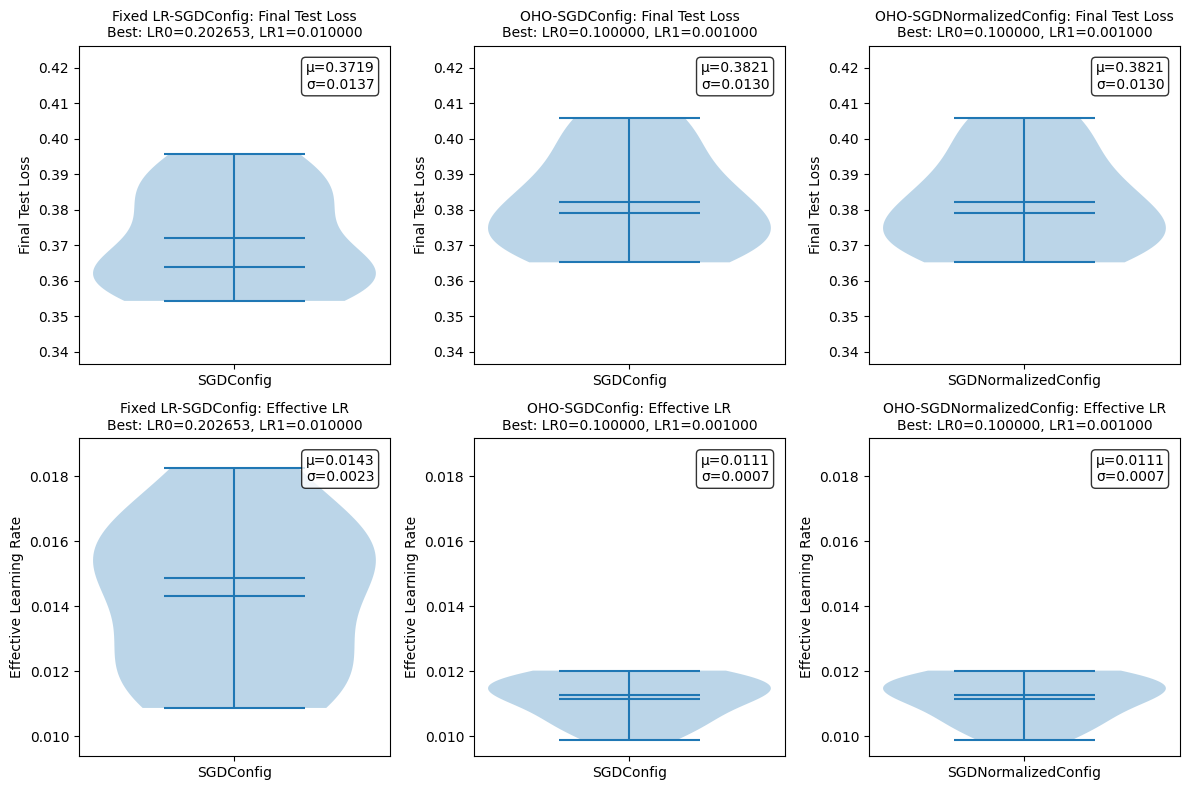

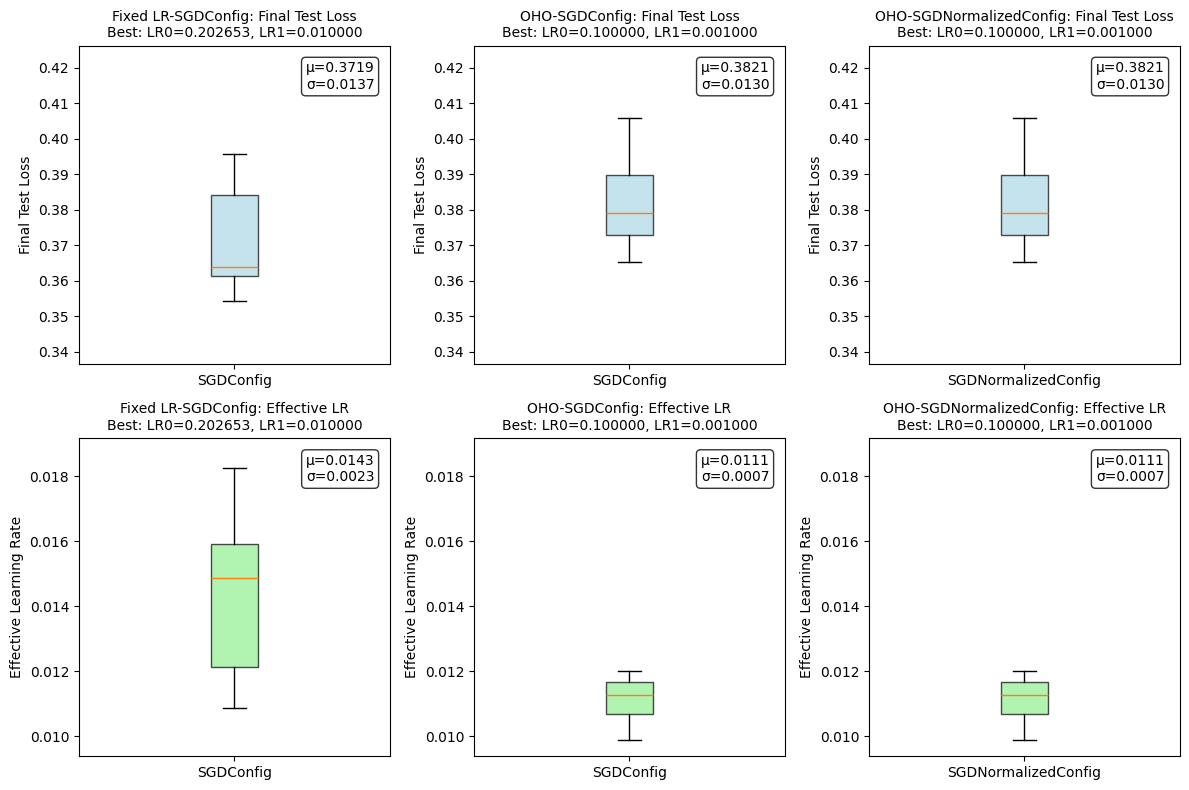

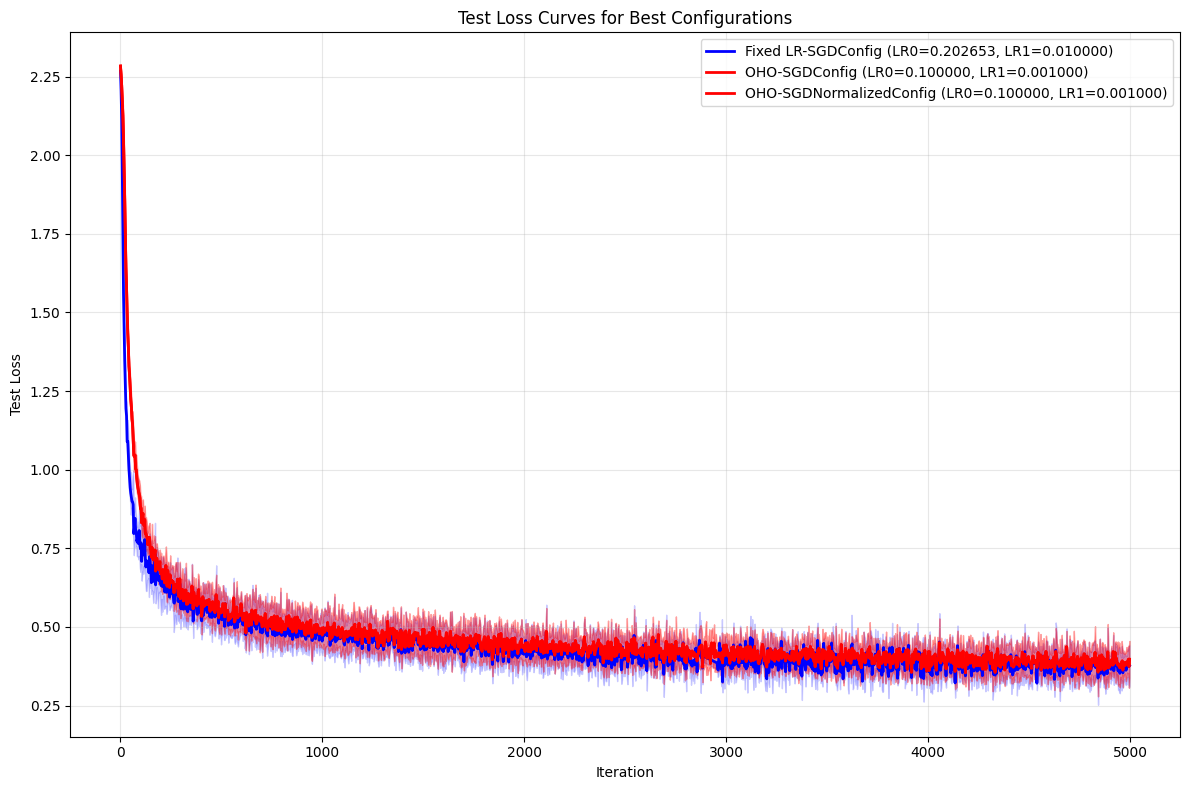

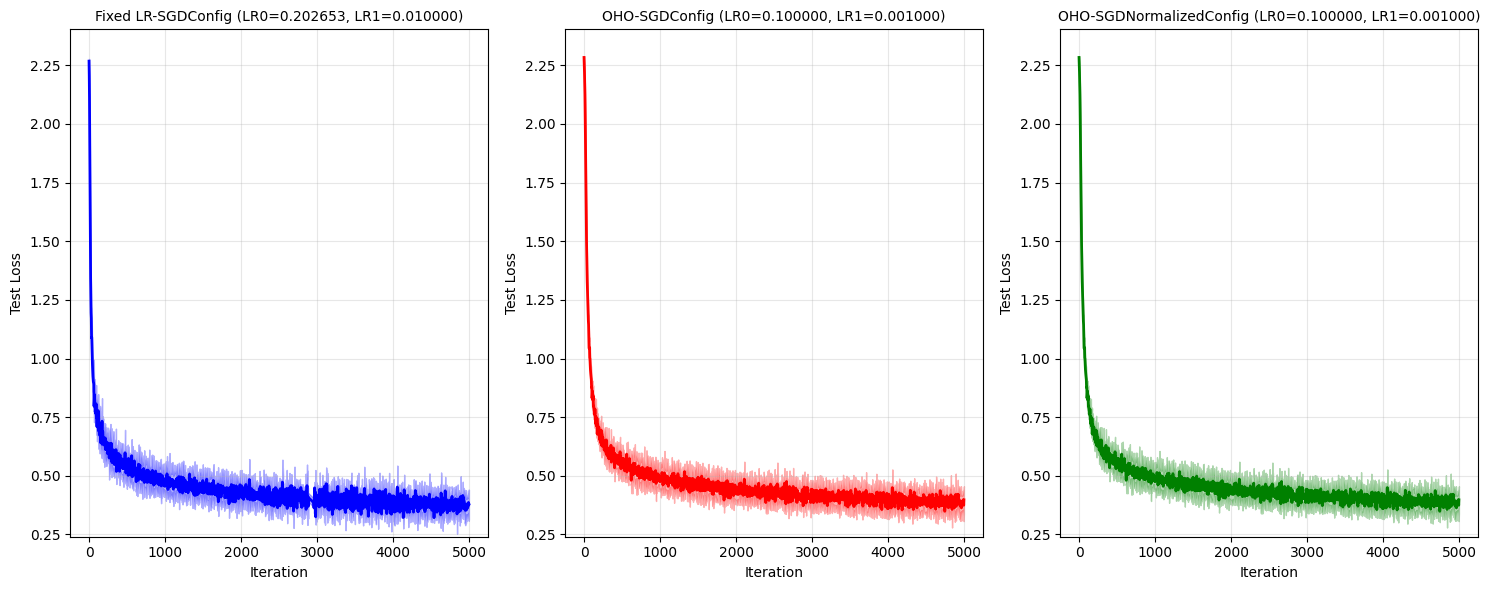

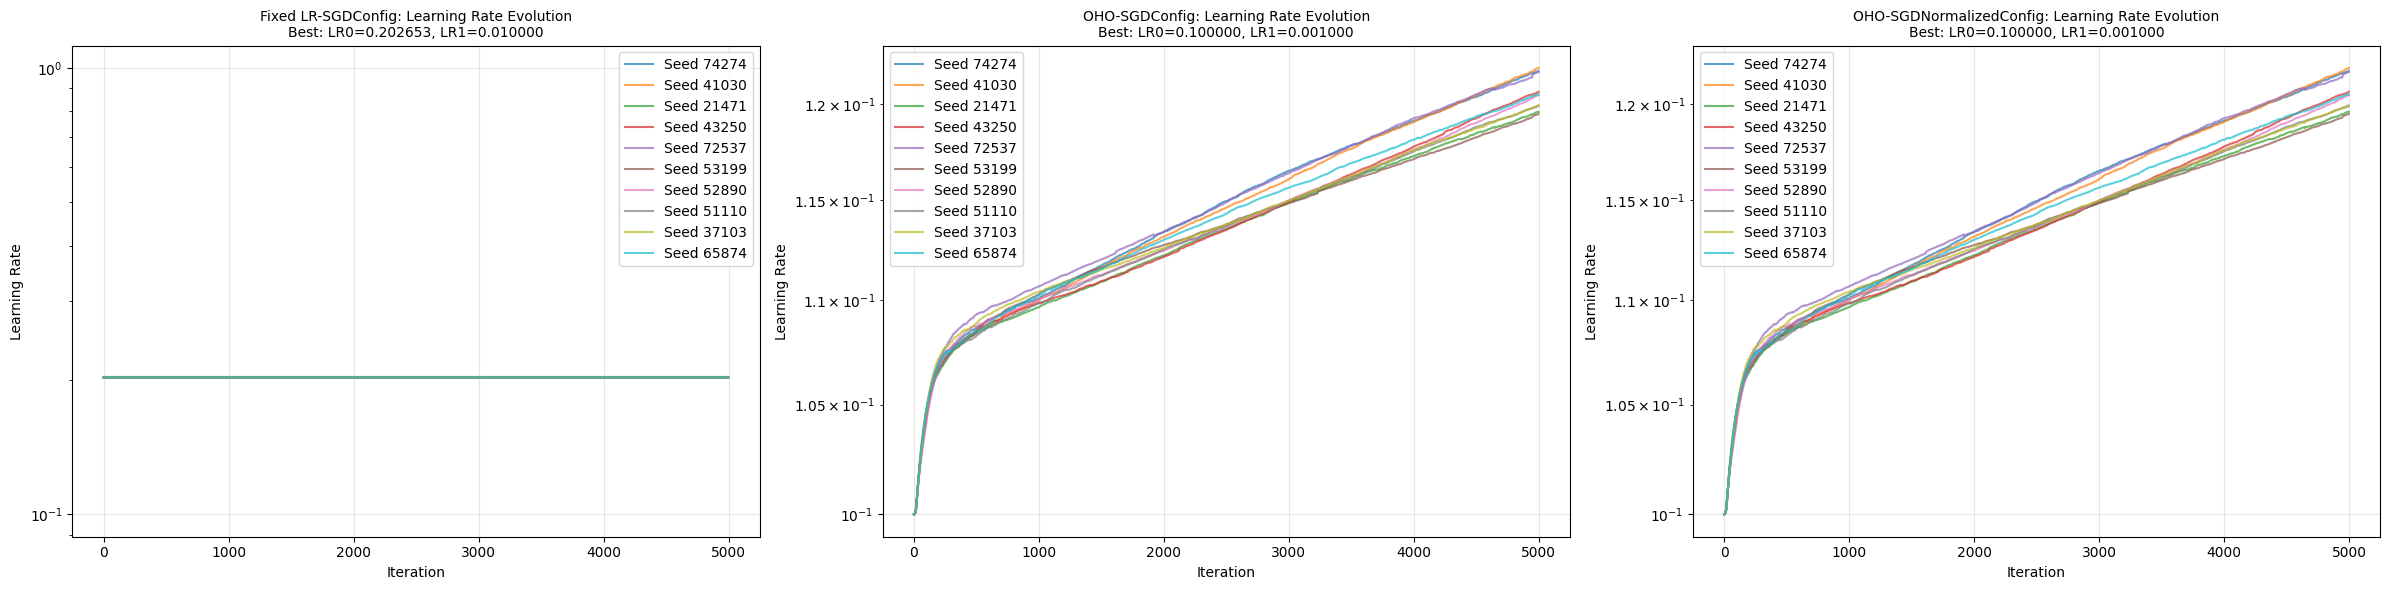


MANN-WHITNEY U TESTS:


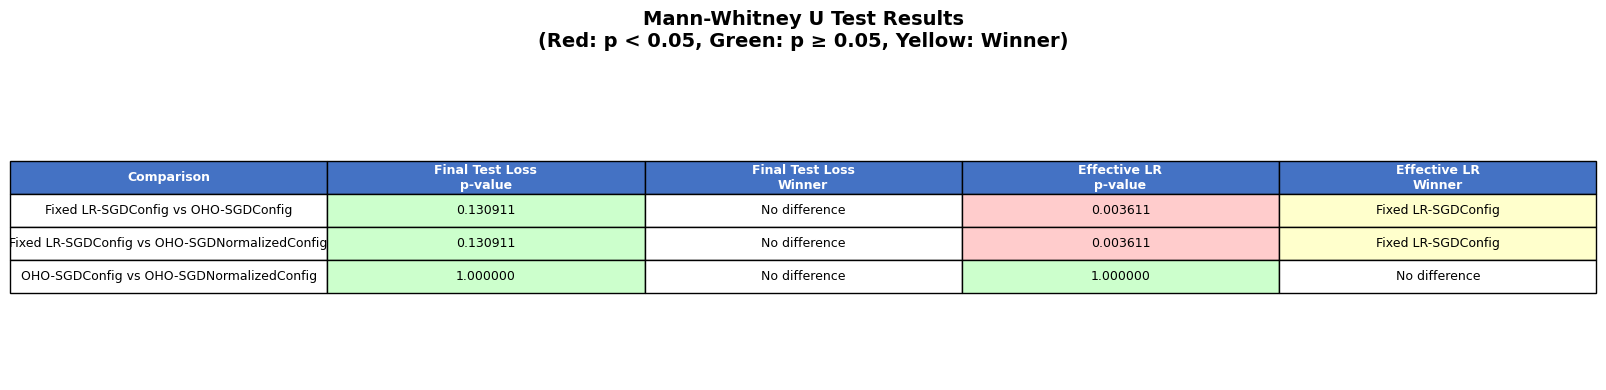


Mann-Whitney U Test Results table displayed above
Note: p < 0.05 indicates significant difference
Final Test Loss: Lower is better
Effective LR: Higher is better (faster convergence)

Fixed LR-SGDConfig vs OHO-SGDConfig:
  Final Test Loss: p=0.130911 - No significant difference
  Effective LR: p=0.003611 - SIGNIFICANT: Fixed LR-SGDConfig has higher effective LR (BETTER)

Fixed LR-SGDConfig vs OHO-SGDNormalizedConfig:
  Final Test Loss: p=0.130911 - No significant difference
  Effective LR: p=0.003611 - SIGNIFICANT: Fixed LR-SGDConfig has higher effective LR (BETTER)

OHO-SGDConfig vs OHO-SGDNormalizedConfig:
  Final Test Loss: p=1.000000 - No significant difference
  Effective LR: p=1.000000 - No significant difference


In [3]:
# Setup experiment configurations
experiment_configs = [
    (df_exp1, "Fixed LR"),
    (df_exp2, "OHO"),
    # Add more as needed: (df_exp3, "EXPERIMENT 3"),
]

# Run analysis
results, dataframes = run_analysis(experiment_configs)

# Plot and test
plot_and_test(results, dataframes)